# Environment

## Libraries

In [3]:
import os, subprocess, json, requests, getpass, urllib.parse, sys, pathlib, warnings, numpy as np, pandas_profiling, seaborn as sns, pandas as pd, matplotlib.pyplot as plt, google.cloud.bigquery as bigquery

from bs4 import BeautifulSoup
from astropy.visualization import hist as astro_hist
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

## Specifying the Working Directory

In [4]:
workingdir = os.getcwd()
d = [d for d in os.listdir(workingdir)]
n = 0
while not set(["notebook"]).issubset(set(d)):
    workingdir = str(pathlib.Path(workingdir).parents[0])

    d = [d for d in os.listdir(str(workingdir))]
    n += 1
    if n > 5:
        break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

## Dealing with Warnings

In [5]:
pd.set_option("mode.chained_assignment", None)

## Function Definitions

In [7]:
def create_wordcloud(df: pd.DataFrame, what: str):
    posts = df[["body"]].apply(lambda x: " ".join(x), axis=0)[0]
    soup = BeautifulSoup(posts, "html.parser")
    obj_array = soup.find_all(what)
    text = ""

    for obj in obj_array:
        text += obj.text

    stopwords = set(STOPWORDS)
    wordcloud_obj = WordCloud(stopwords=stopwords).generate(text)

    return wordcloud_obj

In [8]:
def split_tags(tags: str) -> list:
    return tags.split("|")

## Specifying GCP-Related Variables 

In [9]:
os.environ["PROJECT_ID"] = (
    subprocess.run(
        'gcloud config list project --format "value(core.project)"',
        shell=True,
        check=True,
        stdout=subprocess.PIPE,
    )
    .stdout.decode()
    .replace("\n", "")
    .replace("\r", "")
)
print(os.environ["PROJECT_ID"])

nlp-text-classification


In [10]:
os.environ["BUCKET_NAME"] = "axa-ch-machine-learning-poc-dev"

In [11]:
try:
    tmp = os.environ["PROJECT_ID"]
except:
    print("Env variable PROJECT not defined!")

try:
    tmp = os.environ["BUCKET_NAME"]
except:
    print("Env variable BUCKET_NAME not defined!")

try:
    tmp = os.environ["GOOGLE_APPLICATION_CREDENTIALS"]
except:
    print("Env variable GOOGLE_APPLICATION_CREDENTIALS not defined!")

try:
    tmp = os.environ["REQUESTS_CA_BUNDLE"]
except:
    print("Env variable REQUESTS_CA_BUNDLE not defined!")

try:
    tmp = os.environ["AXA_CH_CA_BUNDLE"]
except:
    print("Env variable AXA_CA_CA_BUNDLE not defined!")

Env variable GOOGLE_APPLICATION_CREDENTIALS not defined!
Env variable REQUESTS_CA_BUNDLE not defined!
Env variable AXA_CA_CA_BUNDLE not defined!


## Does the Connection Work?

In [ ]:
use_proxy = "Y"
proxies = {"https": os.environ["HTTPS_PROXY"], "http": os.environ["HTTP_PROXY"]}

In [ ]:
list_url = [
    "https://www.google.com",
    "http://www.google.com",
    "https://www.example.com",
    "http://www.example.com",
    "https://github.com/j0hannes/cutter-ng",
]

for url in list_url:
    print("")
    print("trying to access:" + url)
    try:
        if use_proxy == "N":
            r = requests.get(url)
        else:
            # SSL deactivated
            # r = requests.get(url,proxies=proxies,verify=False)
            r = requests.get(url, proxies=proxies, verify=True)

        if r.status_code == requests.codes.ok:
            print("=>OK", r.headers["content-type"])
        else:
            # 407 Proxy Authentication Required
            print("=> ??", r.status_code)
    except Exception as inst:
        print("=>FAILED")
        print(type(inst))  # the exception instance
        print(inst.args)  # arguments stored in .args
        print(inst)

# Exploratory Data Analysis

In [12]:
client = bigquery.Client()

## Tags

<a href='https://stackoverflow.com/help/tagging' target='_blank'>What are tags, and how should I use them?</a>

In [ ]:
query = """SELECT
 *
FROM
  `bigquery-public-data.stackoverflow.tags`
ORDER BY
  count desc"""
df_tags = client.query(query).to_dataframe()

### How are the Tags Distributed?

In [ ]:
features = ["count"]

In [ ]:
df_tags[features].describe()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

astro_hist(df_tags["count"], bins="blocks", histtype="stepfilled")

ax.set(ylim=[0, 600], xlabel="Occurences", ylabel="Number of Tags")

In [ ]:
### Which Tags Are Most Frequent?

In [ ]:
df_tags.head()

In [ ]:
df_tags.iloc[0:50].plot(x="tag_name", y="count", kind="bar", figsize=(15, 5));

### Cumulative Frequency of the Most Frequent Tags

NameError: name 'df_tags' is not defined

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


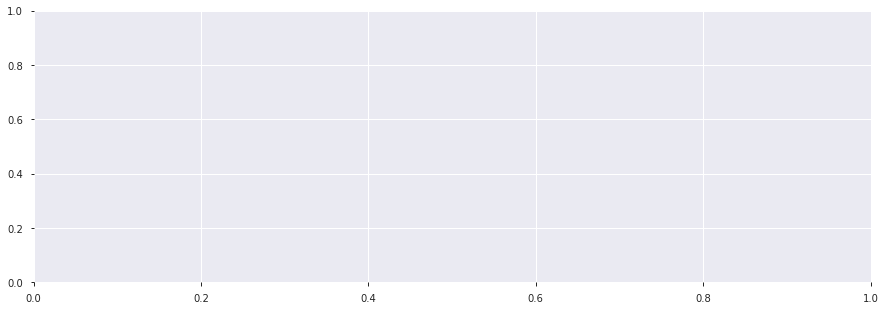

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
total = df_tags["count"].sum()
y_values = []
x_values = []

for category in range(0, len(df_tags), 100):
    value = df_tags["count"].iloc[0:category].sum()
    y_values.append((value / total) * 100)
    x_values.append(category)

ax.plot(x_values, y_values, color="#1f77b4")
ax.set(xlabel="Tag", ylabel="Frequency [%]")
ax.set_xticks(list(range(0, len(df_tags), 4000)) + [len(df_tags)]);

### Cumulative Frequency of Posts in Relation with Labels

In [15]:
query = """SELECT
  {number} as tag_no, COUNT(*) as posts
FROM
  `nlp-text-classification.stackoverflow.posts_p1`
WHERE
  (
  SELECT
    tag_name
  FROM
    `bigquery-public-data.stackoverflow.tags`
  ORDER BY
    count DESC
  LIMIT
    {number} ) IN UNNEST(tags)"""

In [ ]:
df_occurences = client.query(query).to_dataframe()

## Posts

In [ ]:
query = """SELECT
  *
FROM
  `axa-ch-machine-learning-dev.nlp_text_classification.stackoverflow_posts`"""
df_posts = client.query(query).to_dataframe()

In [ ]:
features = [
    "title",
    "body",
    "answer_count",
    "comment_count",
    "favorite_count",
    "score",
    "tags",
    "view_count",
]
report_features = [
    "answer_count",
    "comment_count",
    "favorite_count",
    "score",
    "tags",
    "view_count",
]

In [ ]:
df_posts[features].head()

### Report

In [ ]:
posts_report = df_posts[report_features].profile_report()

In [ ]:
posts_report

### Code: Wordcloud

In [ ]:
df_posts_subset = df_posts[df_posts["tags"] != ""]

In [ ]:
langs = df_tags["tag_name"].iloc[0:10]

In [ ]:
fig = plt.figure(figsize=(15, 20))

for lang, num in zip(langs, range(0, len(langs))):
    temp = df_posts_subset[df_posts_subset["tags"] == lang]
    worcloud_temp = create_wordcloud(temp, "code")

    ax = fig.add_subplot(5, 2, num + 1)

    ax.imshow(worcloud_temp, interpolation="bilinear")
    ax.set(title=lang)
    ax.axis("off")

### Post: Wordcloud

In [ ]:
fig = plt.figure(figsize=(15, 20))

for lang, num in zip(langs, range(0, len(langs))):
    temp = df_posts_subset[df_posts_subset["tags"] == lang]
    worcloud_temp = create_wordcloud(temp, "p")

    ax = fig.add_subplot(5, 2, num + 1)

    ax.imshow(worcloud_temp, interpolation="bilinear")
    ax.set(title=lang)
    ax.axis("off")

## Questions

In [ ]:
query = """SELECT
  *
FROM
  `axa-ch-machine-learning-dev.nlp_text_classification.stackoverflow_posts_questions_small`"""
df_questions = client.query(query).to_dataframe()

In [ ]:
features = [
    "title",
    "body",
    "answer_count",
    "comment_count",
    "favorite_count",
    "score",
    "tags",
    "view_count",
]
report_features = [
    "answer_count",
    "comment_count",
    "favorite_count",
    "score",
    "tags",
    "view_count",
]

In [ ]:
df_questions[features].head()

### Report

In [ ]:
questions_report = df_questions[report_features].profile_report()

In [ ]:
questions_report.to_file(output_file='results/01_reports/questions.html')
questions_report

### Code: Wordcloud

In [ ]:
df_questions_subset = df_questions[df_questions['tags'] != '']

In [ ]:
langs = df_tags['tag_name'].iloc[0:10]

In [ ]:
fig = plt.figure(figsize=(15,20))

for lang, num in zip(langs, range(0, len(langs))):
    temp = df_questions_subset[df_questions_subset['tags'] == lang]
    worcloud_temp = create_wordcloud(temp, 'code')
    
    ax = fig.add_subplot(5, 2, num+1)
                         
    ax.imshow(worcloud_temp, interpolation='bilinear')
    ax.set(title=lang)
    ax.axis('off')   

### Posts: Wordcloud

In [ ]:
fig = plt.figure(figsize=(15,20))

for lang, num in zip(langs, range(0, len(langs))):
    temp = df_questions_subset[df_questions_subset['tags'] == lang]
    worcloud_temp = create_wordcloud(temp, 'p')
    
    ax = fig.add_subplot(5, 2, num+1)
                         
    ax.imshow(worcloud_temp, interpolation='bilinear')
    ax.set(title=lang)
    ax.axis('off')   

## Complete Posts

In [ ]:
query = """SELECT
  *
FROM
  `axa-ch-machine-learning-dev.nlp_text_classification.stackoverflow_posts_complete`"""
df_posts_complete = client.query(query).to_dataframe()

In [ ]:
features = ['title', 'body', 'answer_count', 'comment_count', 'favorite_count', 'score', 'tags', 'view_count']
report_features = ['answer_count', 'comment_count', 'favorite_count', 'score', 'tags', 'view_count']

In [16]:
df_posts_complete[features].head()

NameError: name 'df_posts_complete' is not defined

In [17]:
### Report

In [ ]:
posts_complete_report = df_posts_complete[report_features].profile_report()

In [ ]:
posts_complete_report

### Code: Wordcloud

In [ ]:
df_posts_complete_subset = df_posts_complete[df_posts_complete['tags'] != '']

In [ ]:
langs = df_tags['tag_name'].iloc[0:10]

### Posts: Wordcloud

In [ ]:
fig = plt.figure(figsize=(15,20))

for lang, num in zip(langs, range(0, len(langs))):
    temp = df_posts_complete_subset[df_posts_complete_subset['tags'] == lang]
    worcloud_temp = create_wordcloud(temp, 'p')
    
    ax = fig.add_subplot(5, 2, num+1)
                         
    ax.imshow(worcloud_temp, interpolation='bilinear')
    ax.set(title=lang)
    ax.axis('off')

### How Many Posts Do Have a Codeblock?

In [ ]:
df_posts_complete_subset = df_posts_complete[df_posts_complete['tags'] != '']

In [ ]:
def code_block_number(string):
    soup = BeautifulSoup(string, 'html.parser')
    obj_array = soup.find_all('code')

    return(len(obj_array))

In [ ]:
df_posts_complete_subset['codeblocks'] = df_posts_complete_subset['body'] \
                                            .apply(lambda string: code_block_number(string))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

df_posts_complete_subset['codeblocks'].plot(kind='hist', bins=50, 
                                            weights=np.zeros_like(df_posts_complete_subset['codeblocks']) \
                                            + 1. / df_posts_complete_subset['codeblocks'].size);

ax.set(xlabel='Tag', ylabel='Codeblock Frequency');

### How Much Tags Are There Per Post?

In [ ]:
df_posts_complete_subset['tag_count'] = df_posts_complete_subset['tags'].apply(lambda tags: len(split_tags(tags)))

In [ ]:
df_posts_complete_subset['tag_count'].describe()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

ax.hist(df_posts_complete_subset['tag_count'], width=0.5)

ax.set(xlabel='Number of Tags per Post', xticks=range(1,6), ylabel='Frequency');